In [2]:
import random
from queue import PriorityQueue
import matplotlib.pyplot as plt

In [3]:
oregon_first = "dataset/oregon1_010331.txt"
oregon_second = "dataset/oregon1_010414.txt"
oregon_third = "dataset/oregon1_010421.txt"
oregon_fourth = "dataset/oregon1_010512.txt"
oregon_fifth = "dataset/oregon1_010526.txt"

caida_2006_first = "dataset/as-caida20060102.txt"
caida_2006_second = "dataset/as-caida20060109.txt"
caida_2006_third = "dataset/as-caida20060116.txt"
caida_2006_fourth = "dataset/as-caida20060123.txt"
caida_2006_fifth = "dataset/as-caida20060130.txt"

caida_2007_first = "dataset/as-caida20070101.txt"
caida_2007_second = "dataset/as-caida20070108.txt"
caida_2007_third = "dataset/as-caida20070115.txt"
caida_2007_fourth = "dataset/as-caida20070122.txt"
caida_2007_fifth = "dataset/as-caida20070129.txt"

In [4]:
def my_oracle(file):
    edges = {}
    nodes = {}
    file = open(file, 'r')
    dataset = file.read()
    data = dataset.split("\n")
    data = [x for x in data if "#" not in x]
    data = data[:-1]
    for d in data:
        t = d.split("\t")

        v1 = int(d.split("\t")[0])
        v2 = int(d.split("\t")[1])

        if (v2 in nodes.get(v1, {})) and (v1 in nodes.get(v2, {})):
            continue
        else:
            if v1 in nodes:
                nodes[v1].add(v2)
            else:
                nodes[v1] = {v2}

            if v2 in nodes:
                nodes[v2].add(v1)
            else:
                nodes[v2] = {v1}
            cns = nodes[v1].intersection(nodes[v2])

            for u in cns:
                if u < v1:
                    edges[(u, v1)] += 1
                else:
                    edges[(v1, u)] += 1
                if u < v2:
                    edges[(u, v2)] += 1
                else:
                    edges[(v2, u)] += 1

            if v1 < v2:
                edges[(v1, v2)] = len(cns)
            else:
                edges[(v2, v1)] = len(cns)
    edges_temp = edges
    edges = {k: v for k, v in sorted(edges_temp.items(), key=lambda item: -item[1])[
                              :int(len(edges_temp) * 0.1)]}
    triangles = {k: v for k, v in sorted(edges_temp.items(), key=lambda item: -item[1])[
                                  :int(len(edges_temp))]}
    cnt = 0
    for m in triangles.values():
        cnt += m

    return edges, cnt / 3, len(data)

In [5]:
def update_subgraph(subgraph, v1, v2):
    if v1 in subgraph:
        subgraph[v1].add(v2)
    else:
        subgraph[v1] = {v2}
    if v2 in subgraph:
        subgraph[v2].add(v1)
    else:
        subgraph[v2] = {v1}

In [6]:
from statistics import mean
from datetime import datetime

def arbitrary_order(file, p, space_limit, heavy_space, oracle, evict_light=True):
    start = datetime.now()
    space_used,l1 ,l2 ,l3 = 0,0,0,0
    subgraph = {}
    early_edges,light_edges,heavy_edges = set(),set(),set()
    heavy_queue = PriorityQueue()
    edge_dup = []

    file = open(file, 'r')
    dataset = file.read()
    data = dataset.split("\n")
    data = [x for x in data if "#" not in x]
    data = data[:-1]
    for d in data:
        t = d.split("\t")

        v1 = int(d.split("\t")[0])
        v2 = int(d.split("\t")[1])

        edge_dup.append((v1, v2))

        if (v2, v1) in edge_dup:
            continue

        edge = tuple(sorted((v1, v2)))

        if (v1 in subgraph) and (v2 in subgraph):
            wedge_nodes = subgraph[v1].intersection(subgraph[v2])

            for node in wedge_nodes:

                key0 = tuple(sorted((node, v1)))
                key1 = tuple(sorted((node, v2)))

                n_d = 0
                if key0 in early_edges or key0 in heavy_edges:
                    n_d += 1
                if key1 in early_edges or key1 in heavy_edges:
                    n_d += 1

                if n_d == 2:
                    l3 += 1
                elif n_d == 1:
                    l2 += 1
                else:
                    l1 += 1

        if len(heavy_edges) < heavy_space:
            update_subgraph(subgraph, v1, v2)
            heavy_edges.add(edge)
            pred_triangles = 0
            if edge in oracle:
                pred_triangles = oracle[edge]
            heavy_queue.put((pred_triangles, edge))
            space_used += 1
            continue

        smallest_elem = heavy_queue.get()
        if edge in oracle and oracle[edge] > smallest_elem[0]:
            update_subgraph(subgraph, v1, v2)
            heavy_edges.add(edge)
            heavy_queue.put((oracle[edge], edge))
            old_edge = smallest_elem[1]
            heavy_edges.remove(old_edge)
            if space_used < space_limit:
                early_edges.add(old_edge)
                space_used += 1
            elif random.random() < p:
                if len(early_edges) > 0:
                    evicted = False
                    while (len(early_edges) > 0) and (not evicted):
                        edge_to_evict = early_edges.pop()
                        if random.random() < p:
                            light_edges.add(edge_to_evict)
                        else:
                            w1, w2 = edge_to_evict
                            subgraph[w1].remove(w2)
                            subgraph[w2].remove(w1)
                            evicted = True
                else:
                    if evict_light:
                        edge_to_evict = light_edges.pop()
                        w1, w2 = edge_to_evict
                        subgraph[w1].remove(w2)
                        subgraph[w2].remove(w1)
                    else:
                        space_used += 1
                light_edges.add(old_edge)
            else:
                w1, w2 = old_edge
                subgraph[w1].remove(w2)
                subgraph[w2].remove(w1)
            continue
        else:
            heavy_queue.put(smallest_elem)

        if space_used < space_limit:
            update_subgraph(subgraph, v1, v2)
            early_edges.add(edge)
            space_used += 1
            continue

        elif random.random() < p:
            if len(early_edges) > 0:
                evicted = False
                while (len(early_edges) > 0) and (not evicted):
                    edge_to_evict = early_edges.pop()
                    if random.random() < p:
                        light_edges.add(edge_to_evict)
                    else:
                        w1, w2 = edge_to_evict
                        subgraph[w1].remove(w2)
                        subgraph[w2].remove(w1)
                        evicted = True
            else:
                if evict_light:
                    edge_to_evict = light_edges.pop()
                    w1, w2 = edge_to_evict
                    subgraph[w1].remove(w2)
                    subgraph[w2].remove(w1)
                else:
                    space_used += 1

            update_subgraph(subgraph, v1, v2)
            light_edges.add(edge)
    tc = len(early_edges),len(light_edges),len(heavy_edges )
    return (l1 / (p ** 2) + l2 / p + l3),mean(tc),(datetime.now()-start)



In [7]:
testListOregon = []
trainListOregon = []

testListCaida2006 = []
trainListCaida2006 = []

testListCaida2007 = []
trainListCaida2007 = []
from sklearn.metrics import mean_squared_error
def predict_triangle2(train,test):
    edges = my_oracle(test)
    true_triangle = edges[1]
    true_m = edges[2]
    frac = 0.3
    heavy_space = int(frac * true_triangle)
    p = (true_triangle - heavy_space) / (true_m - heavy_space)
    predicted = arbitrary_order(test, p, true_triangle, heavy_space, my_oracle(train))

    if "oregon" in test:
        testListOregon.append(true_triangle)
        trainListOregon.append(int(predicted[0]))
    if "2006" in test:
        testListCaida2006.append(true_triangle)
        trainListCaida2006.append(int(predicted[0]))
    if "2007" in test:
        testListCaida2007.append(true_triangle)
        trainListCaida2007.append(int(predicted[0]))

    err = abs((predicted[0]-true_triangle)/100)
    print("number of triangle for", test, true_triangle, ", predicted:", int(predicted[0]), ", Space Complexity:",int(predicted[1]),", Runtime:",predicted[2],", Error: ", round(err,3))

In [8]:
predict_triangle2(oregon_first,oregon_second)
predict_triangle2(oregon_first,oregon_third)
predict_triangle2(oregon_first,oregon_fourth)
predict_triangle2(oregon_first,oregon_fifth)
print()
predict_triangle2(caida_2006_first,caida_2006_second)
predict_triangle2(caida_2006_first,caida_2006_third)
predict_triangle2(caida_2006_first,caida_2006_fourth)
predict_triangle2(caida_2006_first,caida_2006_fifth)
print()
predict_triangle2(caida_2007_first,caida_2007_second)
predict_triangle2(caida_2007_first,caida_2007_third)
predict_triangle2(caida_2007_first,caida_2007_fourth)
predict_triangle2(caida_2007_first,caida_2007_fifth)

number of triangle for dataset/oregon1_010414.txt 18237.0 , predicted: 18214 , Space Complexity: 6079 , Runtime: 0:00:03.185761 , Error:  0.227
number of triangle for dataset/oregon1_010421.txt 19108.0 , predicted: 19007 , Space Complexity: 6369 , Runtime: 0:00:03.151645 , Error:  1.009
number of triangle for dataset/oregon1_010512.txt 17598.0 , predicted: 17584 , Space Complexity: 5866 , Runtime: 0:00:03.254089 , Error:  0.133
number of triangle for dataset/oregon1_010526.txt 19894.0 , predicted: 19866 , Space Complexity: 6631 , Runtime: 0:00:03.563987 , Error:  0.279

number of triangle for dataset/as-caida20060109.txt 30689.0 , predicted: 30147 , Space Complexity: 10229 , Runtime: 0:00:29.956339 , Error:  5.413
number of triangle for dataset/as-caida20060116.txt 30884.0 , predicted: 32969 , Space Complexity: 10294 , Runtime: 0:00:33.561539 , Error:  20.851
number of triangle for dataset/as-caida20060123.txt 28418.0 , predicted: 28818 , Space Complexity: 9472 , Runtime: 0:00:30.93826

Text(0, 0.5, 'number  of triangle')

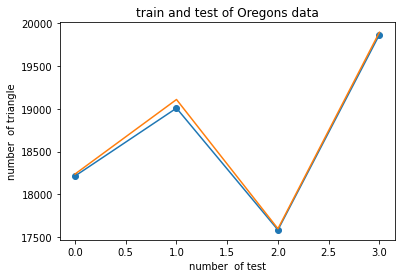

In [9]:
plt.plot(trainListOregon, 'o-')
plt.plot(testListOregon)
plt.title('train and test of Oregons data')
plt.xlabel('number  of test')
plt.ylabel('number  of triangle')

Text(0, 0.5, 'number  of triangle')

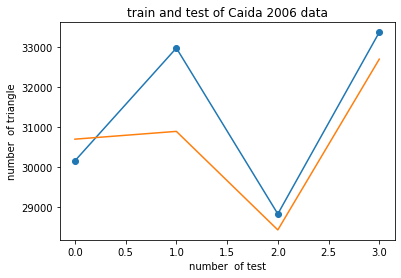

In [10]:
plt.plot(trainListCaida2006, 'o-')
plt.plot(testListCaida2006)
plt.title('train and test of Caida 2006 data')
plt.xlabel('number  of test')
plt.ylabel('number  of triangle')

Text(0, 0.5, 'number  of triangle')

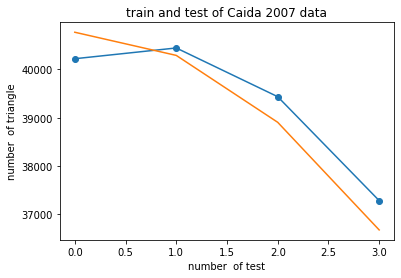

In [11]:
plt.plot(trainListCaida2007, 'o-')
plt.plot(testListCaida2007)
plt.title('train and test of Caida 2007 data')
plt.xlabel('number  of test')
plt.ylabel('number  of triangle')